In [1]:
!nvidia-smi

Sun Oct 23 16:03:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!apt-get install python3.7
!python --version

!pip install -q segmentation_models

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'python3.7-2to3' for regex 'python3.7'
Note, selecting 'libpython3.7-stdlib' for regex 'python3.7'
0 upgraded, 0 newly installed, 0 to remove and 93 not upgraded.
Python 3.7.12


In [3]:
import keras
import tensorflow as tf 

print(tf.__version__)
print(keras.__version__)

2.6.4
2.6.0


In [4]:
# from google.colab import files
# files.upload() #upload kaggle.json

# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json

# !kaggle datasets download -d isaienkov/football-advertising-banners-detection

# !unzip -q /content/football-advertising-banners-detection.zip
# !rm /content/football-advertising-banners-detection.zip

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
import numpy as np
import cv2, zlib, base64, io
from PIL import Image
import json
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from glob import glob

In [7]:
# functions for data conversion. Source: https://docs.supervise.ly/data-organization/00_ann_format_navi/04_supervisely_format_objects#bitmap

def base64_2_mask(s):
    z = zlib.decompress(base64.b64decode(s))
    n = np.fromstring(z, np.uint8)
    mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    return mask

def mask_2_base64(mask):
    img_pil = Image.fromarray(np.array(mask, dtype=np.uint8))
    img_pil.putpalette([0,0,0,255,255,255])
    bytes_io = io.BytesIO()
    img_pil.save(bytes_io, format='PNG', transparency=0, optimize=0)
    bytes = bytes_io.getvalue()
    return base64.b64encode(zlib.compress(bytes)).decode('utf-8')

In [8]:
os.chdir("../input/football-advertising-banners-detection/")

In [9]:
os.getcwd()

'/kaggle/input/football-advertising-banners-detection'

In [10]:
# get all image names
img_path = "football/images"
image_names = os.listdir(img_path)
print(f"Total images: {len(image_names)}")

Total images: 8851


In [11]:
# total number of json files
json_path = "football/annotations"
json_names = os.listdir(json_path)
print(f"Total jsons: {len(json_names)}")

Total jsons: 8936


In [12]:
print(f"Number unique json_names {len(set(json_names))}")

Number unique json_names 8936


In [13]:
img_name_as_json = [img_name + ".json" for img_name in image_names]
json_wo_img = list(set(json_names) - set(img_name_as_json))
print(len(json_wo_img))

85


We have 85 json_files that doesn't have there images

In [14]:
json_wo_img

['07wu2vzq7yjpmno.png.json',
 '67bhbb5p2qfx3og.png.json',
 '738y9l8fd4iysio.png.json',
 'bohip4mjfdorpln.png.json',
 '6l03vira3qvwl20.png.json',
 'cfuhpnkvv4hvdzm.png.json',
 'aigci4egpuo29wk.png.json',
 '9c3dlconrukwmbe.png.json',
 'khmdftji9az5onq.png.json',
 'a22rteg0mehce7j.png.json',
 '3ts13tjtjvr8cby.png.json',
 'ivd4iopk1iza1ki.png.json',
 'bummrl4kf4be7ua.png.json',
 '2y1wmfbo9s3my7n.png.json',
 '7aq3e2di3u4k2s6.png.json',
 '71gen3rcepb2r94.png.json',
 'afpvgwwioyykc6s.png.json',
 '1rbnqe0ed6qlbio.png.json',
 'bhckrzxdgblg3e1.png.json',
 '0h0u2u5guhac5gg.png.json',
 '6xwyhury2iqdpbx.png.json',
 'itiv5lyxdhvfvwa.png.json',
 '8hw686tgatdn4im.png.json',
 'a74l4zupx2rn7ze.png.json',
 '1mvi80lsgh941to.png.json',
 'jmzqdxdylr12e8l.png.json',
 'ak0g9adi97qn4bg.png.json',
 '6k1zbqgb0re63vm.png.json',
 '9ndhq0lxdvp3cox.png.json',
 'ax2lm3ptwybkguc.png.json',
 'c6tkszuyl4jrdvf.png.json',
 '0a4e7fhql48x59t.png.json',
 'bcnhmdf766yme52.png.json',
 '9b8z6ho3809rdfl.png.json',
 '4ic59f5ksemv

In [15]:
# open and load meta.json
with open("football/meta.json") as meta_file:
    meta_json = json.load(meta_file)


In [16]:
all_classes = [item["title"] for item in meta_json["classes"]]
print(all_classes)

['mastercard', 'nissan', 'playstation', 'unicredit', 'pepsi', 'adidas', 'gazprom', 'heineken']


In [17]:
classes_dict = dict(zip(all_classes, [0]*len(all_classes)))
classes_dict["without"] = 0
print(classes_dict)

{'mastercard': 0, 'nissan': 0, 'playstation': 0, 'unicredit': 0, 'pepsi': 0, 'adidas': 0, 'gazprom': 0, 'heineken': 0, 'without': 0}


In [18]:
def open_json(json_name):
    #open .json file and return dictionary 
    with open(json_name) as json_file:
        label = json.load(json_file)
    return label

In [19]:
for item in tqdm(img_name_as_json):
    json_file = open_json('football/annotations/'+item)
    if len(json_file["objects"]) == 0:
        classes_dict["without"] += 1
    else:
        for i in json_file["objects"]:
            classes_dict[i["classTitle"]] += 1
print(classes_dict)
        

100%|██████████| 8851/8851 [01:14<00:00, 119.52it/s]

{'mastercard': 3421, 'nissan': 3113, 'playstation': 3124, 'unicredit': 0, 'pepsi': 2565, 'adidas': 0, 'gazprom': 3292, 'heineken': 3633, 'without': 21}


In [20]:
classes_remove = []

for i in classes_dict.keys():
    if classes_dict[i] == 0:
        classes_remove.append(i)
for i in classes_remove:
    all_classes.remove(i)
    classes_dict.pop(i)
    
print(all_classes)
print(classes_dict)

['mastercard', 'nissan', 'playstation', 'pepsi', 'gazprom', 'heineken']
{'mastercard': 3421, 'nissan': 3113, 'playstation': 3124, 'pepsi': 2565, 'gazprom': 3292, 'heineken': 3633, 'without': 21}


In [21]:
classes_values = dict(zip(all_classes, range(len(all_classes)))) 
print(classes_values)

{'mastercard': 0, 'nissan': 1, 'playstation': 2, 'pepsi': 3, 'gazprom': 4, 'heineken': 5}


In [22]:
import plotly.graph_objects as go
print("Number of labels on all images")

go.Figure(data=[go.Pie(labels=list(classes_dict.keys()), values=list(classes_dict.values()))])


Number of labels on all images


# Show image and mask

In [23]:
def full_mask(json_file):
    # return full mask with corresponding labels
    
    # get dictionary from json file
    json_file = open_json(json_file)
    
    #create mask with zeros
    height = json_file["size"]["height"]
    width = json_file["size"]["width"]
    mask = np.zeros((height, width, 1))
    
    # iterate throug all masks(can be several with different brand and with one)
    for i in range(len(json_file['objects'])):
        # get name of banner
#         label = json_file['objects'][i]["classTitle"]
        
        #convert name to number
#         label_number = classes_values[label]
        label_number = 0
    
        # get bitmap string
        mask_str = json_file['objects'][i]['bitmap']['data']
        
        # convert from bitmap to image(true/false)
        mask_small = base64_2_mask(mask_str)
        
        #get startpoint of mask in image
        start_point = json_file['objects'][i]['bitmap']['origin']
        
#         # paint mask as corresponding number
#         mask[start_point[1]:start_point[1] + mask_small.shape[0],start_point[0]:start_point[0] + mask_small.shape[1]] = (label_number) * mask_small
        
        # mask 0 - not banner 1 - is banner
        mask[start_point[1]:start_point[1] + mask_small.shape[0],
             start_point[0]:start_point[0] + mask_small.shape[1],
             label_number] = mask_small
#     mask[:, :, -1] = np.ones((height ,width)) - np.sum(mask, axis=-1)
    return mask

# Create generator

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



(720, 1280, 1) [0. 1.]


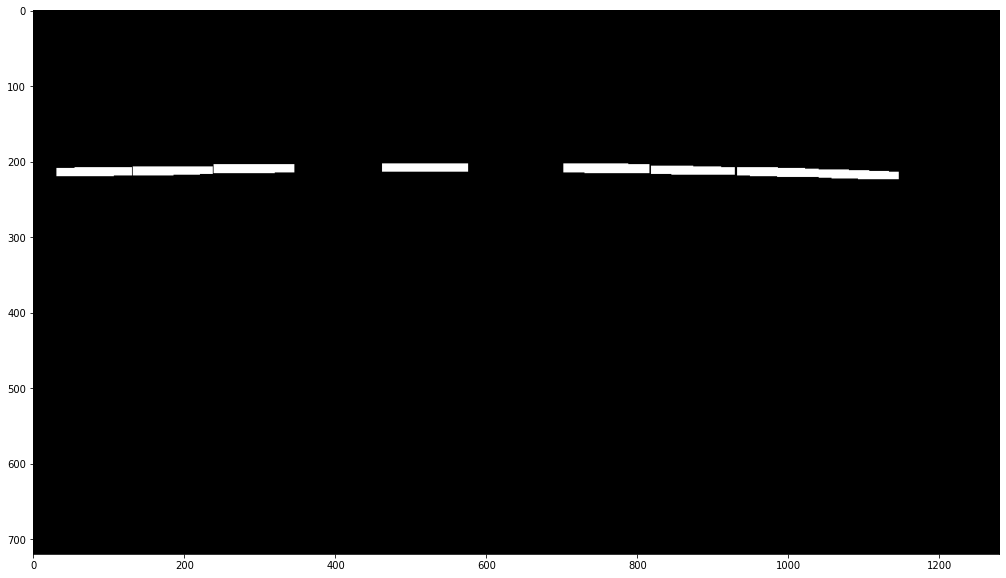

In [24]:
mask = full_mask('football/annotations/ytrd7x5jm6gbxg4.png.json')
print(mask.shape, np.unique(mask))
# mask = np.argmax(mask, axis=2)
# mask = np.where(mask != 0, 1, mask)
plt.figure(figsize=(20, 10))
plt.imshow(mask[:,:,0], cmap='gray')
plt.show()


In [25]:
!mkdir /kaggle/working/masks
!mkdir /kaggle/working/weights

# !rm -rf /kaggle/working/masks

In [26]:
image_names = sorted(glob('football/images/*'))
for i in tqdm(image_names):
    cv2.imwrite('/kaggle/working/masks/'+i.split('/')[-1], full_mask('football/annotations/'+i.split('/')[-1]+'.json'))   
mask_names = sorted(glob('/kaggle/working/masks/*'))

  0%|          | 0/8851 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

100%|██████████| 8851/8851 [00:41<00:00, 212.00it/s]


In [27]:
# for i in tqdm(image_names):
#   img = cv2.imread(i)
#   cv2.imwrite(i[:-4]+'.jpg', img)
#   os.remove(i)
# image_names = sorted(glob('football/images/*'))

In [28]:
len(image_names), len(mask_names)

(8851, 8851)

In [29]:
image_names[:3], mask_names[:3]

(['football/images/004f03mh0td9rm1.png',
  'football/images/0069fqzjts4t90w.png',
  'football/images/006npw4orve4xtm.png'],
 ['/kaggle/working/masks/004f03mh0td9rm1.png',
  '/kaggle/working/masks/0069fqzjts4t90w.png',
  '/kaggle/working/masks/006npw4orve4xtm.png'])

In [30]:
temp1 = []
temp2 = []

for i in tqdm(mask_names):
    mask = cv2.imread(i,0)
    if len(np.unique(mask)) != 2:
        temp1.append(i)
        temp2.append(np.unique(mask))

temp1, temp2

100%|██████████| 8851/8851 [01:54<00:00, 77.46it/s]


(['/kaggle/working/masks/0069fqzjts4t90w.png',
  '/kaggle/working/masks/07zq61gnsmkv02w.png',
  '/kaggle/working/masks/0can7hb2jingi3e.png',
  '/kaggle/working/masks/15q2fe2fk6a5zoe.png',
  '/kaggle/working/masks/1je1lh9t56ik0fz.png',
  '/kaggle/working/masks/54ijh1uqx4zicdv.png',
  '/kaggle/working/masks/86o5ry4rz8ov8ia.png',
  '/kaggle/working/masks/8q8msmee3yc8zma.png',
  '/kaggle/working/masks/8r2cbnvoc926b61.png',
  '/kaggle/working/masks/8uye8ucg0fays6w.png',
  '/kaggle/working/masks/9coqv64r3ijpfav.png',
  '/kaggle/working/masks/9ob8lvjct7pfy5t.png',
  '/kaggle/working/masks/augu4npb7gga1bc.png',
  '/kaggle/working/masks/bbme9us27v2yc7v.png',
  '/kaggle/working/masks/bbvz1k8gvyajbjf.png',
  '/kaggle/working/masks/g5z51ljorpv4t7o.png',
  '/kaggle/working/masks/mw5nlmbooa31iw9.png',
  '/kaggle/working/masks/r4q8iqs7ljl0r15.png',
  '/kaggle/working/masks/shz4rhlhvqey6y6.png',
  '/kaggle/working/masks/v66mf8w30janwru.png',
  '/kaggle/working/masks/v90g656gjunt5fu.png'],
 [array([0],

In [31]:
len(temp1)

21

In [32]:
for i in temp1:
    print(i)
    mask_names.remove(i)
    image_names.remove(i.replace('/kaggle/working/masks', 'football/images'))


len(image_names), len(mask_names)

/kaggle/working/masks/0069fqzjts4t90w.png
/kaggle/working/masks/07zq61gnsmkv02w.png
/kaggle/working/masks/0can7hb2jingi3e.png
/kaggle/working/masks/15q2fe2fk6a5zoe.png
/kaggle/working/masks/1je1lh9t56ik0fz.png
/kaggle/working/masks/54ijh1uqx4zicdv.png
/kaggle/working/masks/86o5ry4rz8ov8ia.png
/kaggle/working/masks/8q8msmee3yc8zma.png
/kaggle/working/masks/8r2cbnvoc926b61.png
/kaggle/working/masks/8uye8ucg0fays6w.png
/kaggle/working/masks/9coqv64r3ijpfav.png
/kaggle/working/masks/9ob8lvjct7pfy5t.png
/kaggle/working/masks/augu4npb7gga1bc.png
/kaggle/working/masks/bbme9us27v2yc7v.png
/kaggle/working/masks/bbvz1k8gvyajbjf.png
/kaggle/working/masks/g5z51ljorpv4t7o.png
/kaggle/working/masks/mw5nlmbooa31iw9.png
/kaggle/working/masks/r4q8iqs7ljl0r15.png
/kaggle/working/masks/shz4rhlhvqey6y6.png
/kaggle/working/masks/v66mf8w30janwru.png
/kaggle/working/masks/v90g656gjunt5fu.png


(8830, 8830)

In [33]:
len(image_names), len(mask_names)

(8830, 8830)

In [34]:
import random
from sklearn.model_selection import train_test_split

    
def load_dataset(images, masks):
    
    train_x, test_x, train_y, test_y = train_test_split(images, masks, test_size=0.3, random_state=1996, shuffle=True)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.15, random_state=1996, shuffle=True)
    
    return train_x, val_x, train_y, val_y, test_x, test_y

train_x, val_x, train_y, val_y, test_x, test_y = load_dataset(image_names, mask_names)
# train_x, val_x, train_y, val_y = train_x[:4000], val_x[:800], train_y[:4000], val_y[:800]
print(len(train_x), len(val_x), len(train_y), len(val_y), len(test_x), len(test_y))

train_X_y_paths = list(zip(train_x, train_y))
val_X_y_paths = list(zip(test_x, test_y))
test_X_y_paths = list(zip(val_x, val_y))
    
def get_data_generator(samples,batch_size):

    while True:

        for offset in range(0, len(samples), batch_size): 
            batch_samples = samples[offset:offset+batch_size]
            X_train = []
            Y_train = []
            
            for batch_sample in batch_samples:

                X_image = cv2.imread(batch_sample[0])[:,:,::-1]
                # print(batch_sample[0],X_image.shape)
                X_image = cv2.resize(X_image, (512, 512))
                X_image = X_image / 255.0
                X_image = X_image.astype(np.float32)

                Y_image = cv2.imread(batch_sample[1], 0)
                Y_image = cv2.resize(Y_image, (512, 512), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
                # print(batch_sample[1],Y_image.shape)
                Y_image = Y_image.astype(np.float32).reshape(X_image.shape[0], X_image.shape[1], 1)
                # Y_image = tf.one_hot(Y_image, 8, dtype = np.float32)

                X_train.append(X_image)
                Y_train.append(Y_image)
        
            yield np.array(X_train), np.array(Y_train)
        
        
BATCH_SIZE = 16
train_generator = get_data_generator(train_X_y_paths,batch_size=BATCH_SIZE)
val_generator = get_data_generator(val_X_y_paths,batch_size=BATCH_SIZE)
test_generator = get_data_generator(test_X_y_paths,batch_size=BATCH_SIZE)

x_train, y_train = next(train_generator)
x_val, y_val  = next(val_generator)
x_test, y_test  = next(test_generator)

print(x_train.shape,y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

5253 928 5253 928 2649 2649
(16, 512, 512, 3) (16, 512, 512, 1)
(16, 512, 512, 3) (16, 512, 512, 1)
(16, 512, 512, 3) (16, 512, 512, 1)


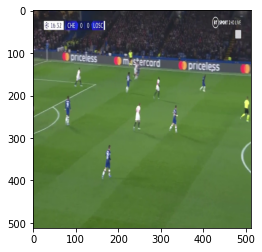

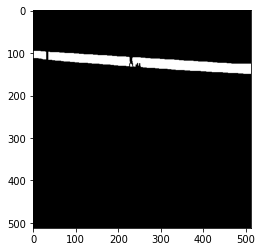

In [35]:
plt.imshow(x_train[0])
plt.show()

plt.imshow(y_train[0], cmap='gray')
plt.show()

# Create model

In [36]:
#@title
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB2


def ASPP(image_features):

  shape = image_features.shape
  
  y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]))(image_features)
  y_pool = Conv2D(filters=32, kernel_size=1, padding='same', use_bias=False)(y_pool)
  y_pool = BatchNormalization(name=f'bn_1')(y_pool)
  y_pool = Activation('relu', name=f'relu_1')(y_pool)
  y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

  y_1 = Conv2D(filters=32, kernel_size=1, padding='same', use_bias=False)(image_features)
  y_1 = BatchNormalization(name=f'bn_2')(y_1)
  y_1 = Activation('relu', name=f'relu_2')(y_1)

  y_6 = Conv2D(filters=32, kernel_size=3, padding='same', dilation_rate = 6,use_bias=False)(image_features)
  y_6 = BatchNormalization(name=f'bn_3')(y_6)
  y_6 = Activation('relu', name=f'relu_3')(y_6)

  y_12 = Conv2D(filters=32, kernel_size=1, padding='same', dilation_rate = 12,use_bias=False)(image_features)
  y_12 = BatchNormalization(name=f'bn_4')(y_12)
  y_12 = Activation('relu', name=f'relu_4')(y_12)

  y_18 = Conv2D(filters=32, kernel_size=3, padding='same', dilation_rate = 6,use_bias=False)(image_features)
  y_18 = BatchNormalization(name=f'bn_5')(y_18)
  y_18 = Activation('relu', name=f'relu_5')(y_18)

  y_c = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

  y = Conv2D(filters=32, kernel_size=1, padding='same', use_bias=False)(y_c)
  y = BatchNormalization(name=f'bn_6')(y)
  y = Activation('relu', name=f'relu_6')(y)

  return y


def DeepLabV3Plus(inputs, classes=1):

    inputs = Input(inputs)

    base_model = EfficientNetB2(weights='imagenet', include_top=False, input_tensor=inputs, drop_connect_rate=0.25)
    high_level_image_features = base_model.get_layer('block6a_expand_bn').output

    x_a = ASPP(high_level_image_features)
    x_a = UpSampling2D(size=4, interpolation='bilinear')(x_a)

    low_level_image_features = base_model.get_layer('block3a_expand_bn').output

    x_b = Conv2D(filters=32, kernel_size=1, padding='same', use_bias=False)(low_level_image_features)
    x_b = BatchNormalization(name=f'bn_7')(x_b)
    x_b = Activation('relu', name=f'relu_7')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=32, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_8')(x)
    x = Activation('relu', name=f'relu_8')(x)

    x = Conv2D(filters=32, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_9')(x)
    x = Activation('relu', name=f'relu_9')(x)

    x = UpSampling2D(size=4, interpolation='bilinear')(x)

    """ Outputs """
    x = Conv2D(classes, (1, 1), name='output_layer')(x)
    
    if classes == 1:
      x = Activation('sigmoid')(x)
    else:
      x = Activation('softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    
    return model


In [37]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input, GlobalAveragePooling2D, Dense, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0


def SqueezeAndExcitation(inputs, ratio=8):
    
    b, h, w, c = inputs.shape
    
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(c//ratio, activation='relu', use_bias=False)(x)
    x = Dense(c, activation='sigmoid', use_bias=False)(x)
    
    x = Multiply()([inputs, x])
    
    return x


def ASPP(image_features):

    shape = image_features.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]))(image_features)
    y_pool = Conv2D(filters=32, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=32, kernel_size=1, padding='same', use_bias=False)(image_features)
    y_1 = BatchNormalization(name=f'bn_2')(y_1)
    y_1 = Activation('relu', name=f'relu_2')(y_1)

    y_6 = Conv2D(filters=32, kernel_size=3, padding='same', dilation_rate = 6,use_bias=False)(image_features)
    y_6 = BatchNormalization(name=f'bn_3')(y_6)
    y_6 = Activation('relu', name=f'relu_3')(y_6)

    y_12 = Conv2D(filters=32, kernel_size=1, padding='same', dilation_rate = 12,use_bias=False)(image_features)
    y_12 = BatchNormalization(name=f'bn_4')(y_12)
    y_12 = Activation('relu', name=f'relu_4')(y_12)

    y_18 = Conv2D(filters=32, kernel_size=3, padding='same', dilation_rate = 6,use_bias=False)(image_features)
    y_18 = BatchNormalization(name=f'bn_5')(y_18)
    y_18 = Activation('relu', name=f'relu_5')(y_18)

    y_c = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=32, kernel_size=1, padding='same', use_bias=False)(y_c)
    y = BatchNormalization(name=f'bn_6')(y)
    y = Activation('relu', name=f'relu_6')(y)

    return y


def DeepLabV3PlusSE(inputs, classes=1):

    inputs = Input(inputs)

    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=inputs, drop_connect_rate=0.25)
    high_level_image_features = base_model.get_layer('block6a_expand_bn').output
    high_level_image_features = SqueezeAndExcitation(high_level_image_features, ratio=16)
    
    x_a = ASPP(high_level_image_features)
    x_a = SqueezeAndExcitation(x_a, ratio=16)
    x_a = UpSampling2D(size=4, interpolation='bilinear')(x_a)

    low_level_image_features = base_model.get_layer('block3a_expand_bn').output
    low_level_image_features = SqueezeAndExcitation(low_level_image_features, ratio=16)
    
    x_b = Conv2D(filters=32, kernel_size=1, padding='same', use_bias=False)(low_level_image_features)
    x_b = BatchNormalization(name=f'bn_7')(x_b)
    x_b = Activation('relu', name=f'relu_7')(x_b)

    x = Concatenate()([x_a, x_b])
    x  = SqueezeAndExcitation(x, ratio=16)

    x = Conv2D(filters=32, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_8')(x)
    x = Activation('relu', name=f'relu_8')(x)

    x = Conv2D(filters=32, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_9')(x)
    x = Activation('relu', name=f'relu_9')(x)

    x = UpSampling2D(size=4, interpolation='bilinear')(x)

    """ Outputs """
    x = Conv2D(filters=classes, kernel_size=1, name='output_layer')(x)
    
    if classes == 1:
        x = Activation('sigmoid')(x)
    else:
        x = Activation('softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    
    return model
  
  
#   def main():

#     model = DeepLabV3PlusSE(inputs=(1024,1024,3), classes=4)
#     model.summary()


# if __name__== '__main__':

#     main()

In [38]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
%env SM_FRAMEWORK=tf.keras

import numpy as np
import tensorflow as tf
from keras import backend as K 
from segmentation_models.losses import bce_jaccard_loss, dice_loss, JaccardLoss
from segmentation_models.metrics import iou_score, f1_score, precision, recall
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
# from DeepLabV3 import DeepLabV3Plus
# from PSPNet import PSPNet


""" Paramaters """
input_shape = (512, 512, 3)
epochs = 1000
lr = 1e-2
csv_path = "/kaggle/working/history.csv"
model_name = 'DeepLabV3PlusSE'
n_classes = 1


""" callbacks """
checkpoint_filepath = '/kaggle/working/weights/Face_Seg_00{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_iou_score',
    mode='max',
    verbose = 1,
    period = 3,
    save_best_only=False
    )

callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=4, factor=0.1, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor="val_loss", patience=10)
]


""" steps per epochs """
train_steps = len(train_x)//BATCH_SIZE
if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1

val_steps = len(val_x)//BATCH_SIZE
if len(val_x) % BATCH_SIZE != 0:
    val_steps += 1

print(train_steps, val_steps)


""" Model training """
ls = dice_loss + bce_jaccard_loss
metrics = [precision, recall, f1_score, iou_score] 

K.clear_session()
if model_name == 'DeepLabV3Plus': 
    model = DeepLabV3Plus(inputs=input_shape, classes=n_classes)
elif model_name == 'DeepLabV3PlusSE': 
    model = DeepLabV3PlusSE(inputs=input_shape, classes=n_classes)
# model.summary()
model.load_weights('/kaggle/input/footballseg/Face_Seg_009.h5')

model.compile(
    loss=ls,
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
    metrics=metrics
)

h = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=callbacks,
    batch_size=BATCH_SIZE,
    workers=-1,
    use_multiprocessing=True,
    initial_epoch = 9
)

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
329 58
16719872/16705208 [==============================] - 0s 0us/step
Epoch 10/1000
329/329 [==============================] - 546s 2s/step - loss: 0.1416 - precision: 0.9497 - recall: 0.9602 - f1-score: 0.9549 - iou_score: 0.9137 - val_loss: 0.1478 - val_precision: 0.9508 - val_recall: 0.9550 - val_f1-score: 0.9529 - val_iou_score: 0.9100
Epoch 11/1000
329/329 [==============================] - 442s 1s/step - loss: 0.1411 - precision: 0.9499 - recall: 0.9604 - f1-score: 0.9550 - iou_score: 0.9140 - val_loss: 0.1563 - val_precision: 0.9500 - val_recall: 0.9505 - val_f1-score: 0.9502 - val_iou_score: 0.9051
Epoch 12/1000
329/329 [==============================] - 440s 1s/step - loss: 0.1410 - precision: 0.9501 - recall: 0.9603 - f1-score: 0.9551 - iou_score: 0.9140 - val_loss: 0.2076 - val_precision: 0.9391 - val_recall: 0.9283 - val_f1-score: 0.9335 - val_iou_score: 0.8754

Epoch 00012: saving model to /kaggl

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 13/1000
329/329 [==============================] - 428s 1s/step - loss: 0.1409 - precision: 0.9500 - recall: 0.9603 - f1-score: 0.9551 - iou_score: 0.9141 - val_loss: 0.2049 - val_precision: 0.9408 - val_recall: 0.9285 - val_f1-score: 0.9345 - val_iou_score: 0.8772
Epoch 14/1000
329/329 [==============================] - 433s 1s/step - loss: 0.1401 - precision: 0.9503 - recall: 0.9606 - f1-score: 0.9554 - iou_score: 0.9146 - val_loss: 0.1590 - val_precision: 0.9376 - val_recall: 0.9618 - val_f1-score: 0.9495 - val_iou_score: 0.9039

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 15/1000
329/329 [==============================] - 427s 1s/step - loss: 0.1395 - precision: 0.9501 - recall: 0.9612 - f1-score: 0.9556 - iou_score: 0.9149 - val_loss: 0.1445 - val_precision: 0.9496 - val_recall: 0.9583 - val_f1-score: 0.9539 - val_iou_score: 0.9119

Epoch 00015: saving model to /kaggle/working/weights/Face_Seg_0015.h5
Epoch 16/1000
329/329 [=========

dict_keys(['loss', 'precision', 'recall', 'f1-score', 'iou_score', 'val_loss', 'val_precision', 'val_recall', 'val_f1-score', 'val_iou_score', 'lr']) 



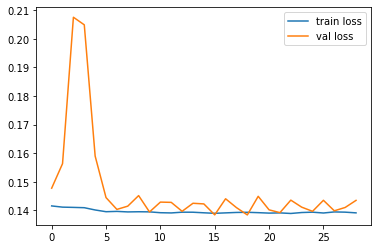

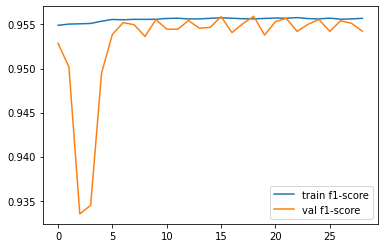

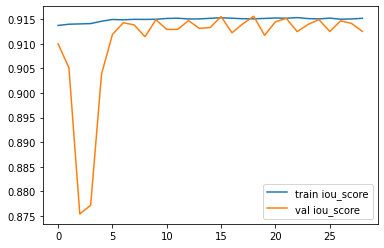

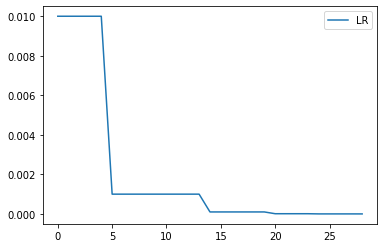

In [39]:
print(h.history.keys(),"\n")

import matplotlib.pyplot as plt

plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(h.history['f1-score'], label='train f1-score')
plt.plot(h.history['val_f1-score'], label='val f1-score')
plt.legend()
plt.show()

plt.plot(h.history['iou_score'], label='train iou_score')
plt.plot(h.history['val_iou_score'], label='val iou_score')
plt.legend()
plt.show()

plt.plot(h.history['lr'], label='LR')
plt.legend()
plt.show()

In [40]:
model.save('/kaggle/working/weights/Face_last.h5')

In [41]:
# from keras.models import load_model
# from segmentation_models.losses import bce_jaccard_loss, dice_loss, JaccardLoss
# from segmentation_models.metrics import iou_score, f1_score, precision, recall

# ls = dice_loss + bce_jaccard_loss
# metrics = [precision, recall, f1_score, iou_score] 
# input_shape = (512, 512, 3)
# epochs = 1000
# lr = 1e-1
# csv_path = "/kaggle/working/history.csv"
# n_classes = 1

# inference_model = DeepLabV3Plus(inputs=input_shape, classes=n_classes)
# inference_model.load_weights('/kaggle/input/footballads/Face_Seg_0030.h5')
# # inference_model = load_model('/kaggle/input/footballads/Face_Seg_0030.h5', compile = False)
# inference_model.compile(
#     loss=ls,
#     optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
#     metrics=metrics
# )


In [42]:
test_steps = len(test_x)//BATCH_SIZE
if len(test_x) % BATCH_SIZE != 0:
    test_steps += 1
    
print(test_steps)    

model.evaluate(test_generator, batch_size=BATCH_SIZE, steps=test_steps, workers=-1, use_multiprocessing=True)

166
166/166 [==============================] - 140s 845ms/step - loss: 0.1425 - precision: 0.9489 - recall: 0.9605 - f1-score: 0.9546 - iou_score: 0.9132


[0.14250874519348145,
 0.9489377737045288,
 0.9604578614234924,
 0.9546301960945129,
 0.9132245779037476]

In [43]:
test_x[42], test_y[42]

('football/images/0cy205prn9umyys.png',
 '/kaggle/working/masks/0cy205prn9umyys.png')

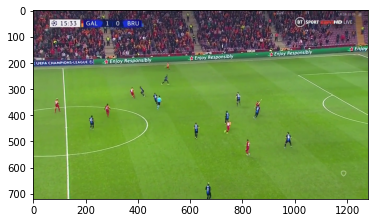

In [44]:
img = cv2.imread(test_x[42])[:,:,::-1]
plt.imshow(img)
plt.show()
img = cv2.resize(img, (512,512))
img = img/255.0

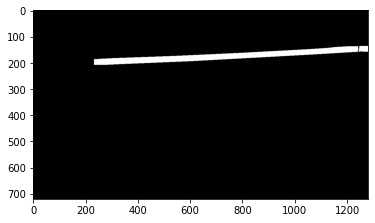

In [45]:
mask = cv2.imread(test_y[42],0)
# mask = cv2.resize(mask, (512,512), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
plt.imshow(mask, cmap='gray')
plt.show()

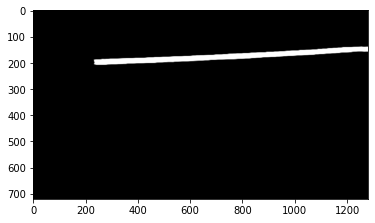

In [46]:
pred = model.predict(img.reshape(1, 512, 512, 3))
pred = cv2.resize(pred.reshape(512, 512), (1280, 720), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
# pred = np.argmax(pred, axis = 3)
plt.imshow(pred, cmap='gray')
plt.show()

In [47]:
test_x[1996], test_y[1996]

('football/images/qakzmgjyxt59qpq.png',
 '/kaggle/working/masks/qakzmgjyxt59qpq.png')

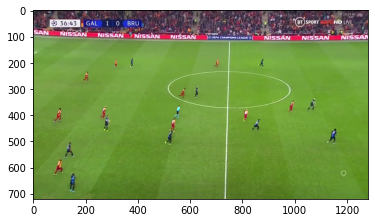

In [48]:
img = cv2.imread(test_x[1996])[:,:,::-1]
plt.imshow(img)
plt.show()
img = cv2.resize(img, (512,512))
img = img/255.0

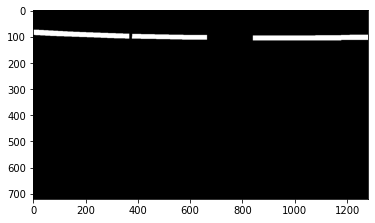

In [49]:
mask = cv2.imread(test_y[1996],0)
# mask = cv2.resize(mask, (512,512), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
plt.imshow(mask, cmap='gray')
plt.show()

In [50]:
cv2.imwrite('/kaggle/working/mask_qakzmgjyxt59qpq.png', mask*255.0)

True

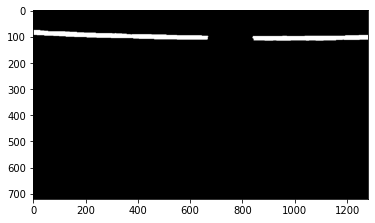

In [51]:
pred = model.predict(img.reshape(1, 512, 512, 3))
pred = np.where(pred >= 0.5, 1, 0)
# pred = np.argmax(pred, axis = 3)
pred = cv2.resize(pred.reshape(512, 512), (1280, 720), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
plt.imshow(pred, cmap='gray')
plt.show()

In [52]:
cv2.imwrite('/kaggle/working/pred_qakzmgjyxt59qpq.png', pred*255.0)

True

In [53]:
np.unique(pred)

array([0, 1], dtype=int32)

In [54]:
test_x[16], test_y[16]

('football/images/6mvtesswrtlhxgo.png',
 '/kaggle/working/masks/6mvtesswrtlhxgo.png')

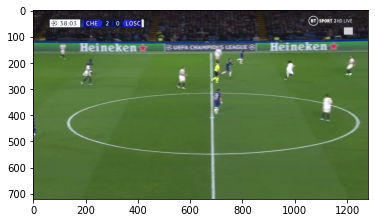

In [55]:
img = cv2.imread(test_x[16])[:,:,::-1]
plt.imshow(img)
plt.show()
img = cv2.resize(img, (512,512))
img = img/255.0

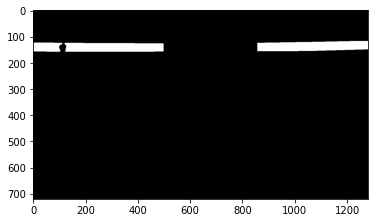

In [56]:
mask = cv2.imread(test_y[16],0)
# mask = cv2.resize(mask, (512,512), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
plt.imshow(mask, cmap='gray')
plt.show()

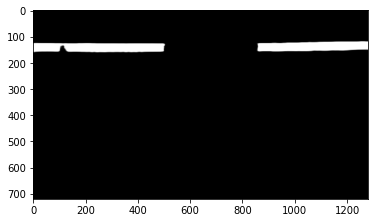

In [57]:
pred = model.predict(img.reshape(1, 512, 512, 3))
# pred = np.argmax(pred, axis = 3)
pred = cv2.resize(pred.reshape(512, 512), (1280, 720), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
plt.imshow(pred, cmap='gray')
plt.show()

In [58]:
import tensorflow as tf
tf.keras.models.save_model(
    model,
    '/kaggle/working/weights/',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

